In [ ]:
# Mount Google Drive, load API keys for Quandl, and set up environment variables for API access
from google.colab import drive
import json

drive.mount('/content/drive')

from pathlib import Path
HDF_PATH = Path('drive', 'MyDrive', 'ML4T', 'assets.h5')

Mounted at /content/drive


In [ ]:
# Download the TA-Lib source files from the official source using wget.
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz

# Extract the tar.gz file to access the source files.
!tar -xvzf ta-lib-0.4.0-src.tar.gz

# Change the directory to the extracted folder to run configuration and installation commands.
%cd ta-lib

# Configure the installation of TA-Lib for the system.
!./configure --prefix=/usr

# Compile the TA-Lib source files.
!make

# Install the compiled TA-Lib to the system directory.
!sudo make install

# Navigate back to the parent directory after installation is complete.
%cd ../

# Install the TA-Lib Python wrapper which allows the use of TA-Lib within Python scripts.
!pip install TA-Lib

--2024-08-02 08:25:26--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 204.68.111.105
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|204.68.111.105|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2024-08-02 08:25:26--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 204.68.111.105
Reusing existing connection to prdownloads.sourceforge.net:80.
HTTP request sent, awaiting response... 302 Found
Location: http://netactuate.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz?viasf=1 [following]
--2024-08-02 08:25:26--  http://netactuate.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz?viasf=1
Res

# Preparing Alpha Factors and Features to predict Stock Returns


## Imports & Settings


In [ ]:
# Suppress warnings for clean output
import warnings
warnings.filterwarnings('ignore')


In [ ]:
# Importing necessary libraries
%matplotlib inline

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr, spearmanr
from talib import RSI, BBANDS, MACD, ATR


In [ ]:
# Define constants for time periods
MONTH = 21  # Number of trading days in a month
YEAR = 12 * MONTH  # Number of trading days in a year

# Define the date range for the data
START = '2013-01-01'
END = '2017-12-31'

# Set the seaborn style for the plots
sns.set_style('whitegrid')

# Create an index slice object
idx = pd.IndexSlice


# Loading Quandl Wiki Stock Prices & Meta Data

In [ ]:
# Define the OHLCV columns
ohlcv = ['adj_open', 'adj_close', 'adj_low', 'adj_high', 'adj_volume']

# Path to the data store
DATA_STORE = HDF_PATH

# Load data from the HDF5 store
with pd.HDFStore(DATA_STORE) as store:
    # Load and process the price data
    prices = (store['quandl/wiki/prices']
              .loc[idx[START:END, :], ohlcv]  # Select data within the date range and columns
              .rename(columns=lambda x: x.replace('adj_', ''))  # Remove 'adj_' prefix from column names
              .assign(volume=lambda x: x.volume.div(1000))  # Convert volume to thousands
              .swaplevel()  # Swap the levels of the MultiIndex
              .sort_index())  # Sort the index

    # Load stock metadata and rename columns
    stocks = (store['us_equities/stocks']
              .loc[:, ['market cap', 'ipo year', 'sector']]
              .rename(columns={'market cap': 'marketcap', 'ipo year': 'ipoyear'}))  # Rename columns


# Remove stocks with few observations

In [ ]:
# Define the minimum number of observations required (2 years of data)
min_obs = 2 * YEAR

# Count the number of observations per ticker
nobs = prices.groupby(level='ticker').size()

# Identify tickers that have more than the minimum number of observations
keep = nobs[nobs > min_obs].index

# Filter the prices data to keep only the selected tickers
prices = prices.loc[idx[keep, :], :]


## Align price and meta data

In [ ]:
# Remove duplicated tickers and entries with missing sector information
stocks = stocks[~stocks.index.duplicated() & stocks.sector.notnull()]

# Standardize sector names to lowercase and replace spaces with underscores
stocks.sector = stocks.sector.str.lower().str.replace(' ', '_')

# Set the index name to 'ticker'
stocks.index.name = 'ticker'

# Find shared tickers between the price and stock metadata
shared = (prices.index.get_level_values('ticker').unique()
          .intersection(stocks.index))

# Filter the stocks and prices data to keep only the shared tickers
stocks = stocks.loc[shared, :]
prices = prices.loc[idx[shared, :], :]

# Display information about the filtered prices data
prices.info(show_counts=True)


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2145582 entries, ('A', Timestamp('2013-01-02 00:00:00')) to ('ZUMZ', Timestamp('2017-12-29 00:00:00'))
Data columns (total 5 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   open    2145582 non-null  float64
 1   close   2145582 non-null  float64
 2   low     2145582 non-null  float64
 3   high    2145582 non-null  float64
 4   volume  2145582 non-null  float64
dtypes: float64(5)
memory usage: 90.8+ MB


In [ ]:
stocks.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 1739 entries, A to ZUMZ
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   marketcap  1739 non-null   float64
 1   ipoyear    787 non-null    float64
 2   sector     1739 non-null   object 
dtypes: float64(2), object(1)
memory usage: 54.3+ KB


In [ ]:
stocks.sector.value_counts()

,count
sector,
consumer_discretionary,429
finance,321
industrials,252
technology,193
health_care,186
real_estate,110
utilities,73
energy,68
consumer_staples,52


## Save and Reload Data

This section saves the processed prices and stocks data to a temporary HDF5 file and then reloads it to ensure data integrity.


In [ ]:
# Save the processed prices and stocks data to a temporary HDF5 file
with pd.HDFStore('tmp.h5') as store:
    store.put('prices', prices)
    store.put('stocks', stocks)

# Reload the data from the temporary HDF5 file
with pd.HDFStore('tmp.h5') as store:
    prices = store['prices']
    stocks = store['stocks']


# Compute Rolling Average Dollar Volume

## Compute Dollar Volume to Determine Universe

In this section, we compute the dollar volume for each ticker to help determine the trading universe. Dollar volume is calculated as the product of the closing price and the trading volume. We also compute the 1-month rolling average of the dollar volume.


In [ ]:
# Compute dollar volume as the product of closing price and volume
prices['dollar_vol'] = prices['close'] * prices['volume']

# Compute the 1-month rolling average of the dollar volume
prices['dollar_vol_1m'] = prices.groupby('ticker')['dollar_vol'].rolling(window=21).mean().reset_index(level=0, drop=True)

# Display information about the prices data including the new columns
prices.info(show_counts=True)


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2145582 entries, ('A', Timestamp('2013-01-02 00:00:00')) to ('ZUMZ', Timestamp('2017-12-29 00:00:00'))
Data columns (total 7 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   open           2145582 non-null  float64
 1   close          2145582 non-null  float64
 2   low            2145582 non-null  float64
 3   high           2145582 non-null  float64
 4   volume         2145582 non-null  float64
 5   dollar_vol     2145582 non-null  float64
 6   dollar_vol_1m  2110802 non-null  float64
dtypes: float64(7)
memory usage: 123.5+ MB


In [ ]:
# Rank tickers by their 1-month rolling average dollar volume on each date
prices['dollar_vol_rank'] = (prices.groupby('date')
                             .dollar_vol_1m
                             .rank(ascending=False))

# Display information about the prices data including the new column
prices.info(show_counts=True)


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2145582 entries, ('A', Timestamp('2013-01-02 00:00:00')) to ('ZUMZ', Timestamp('2017-12-29 00:00:00'))
Data columns (total 8 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   open             2145582 non-null  float64
 1   close            2145582 non-null  float64
 2   low              2145582 non-null  float64
 3   high             2145582 non-null  float64
 4   volume           2145582 non-null  float64
 5   dollar_vol       2145582 non-null  float64
 6   dollar_vol_1m    2110802 non-null  float64
 7   dollar_vol_rank  2110802 non-null  float64
dtypes: float64(8)
memory usage: 139.9+ MB


# Add some Basic Factors
## Compute the Relative Strength Index

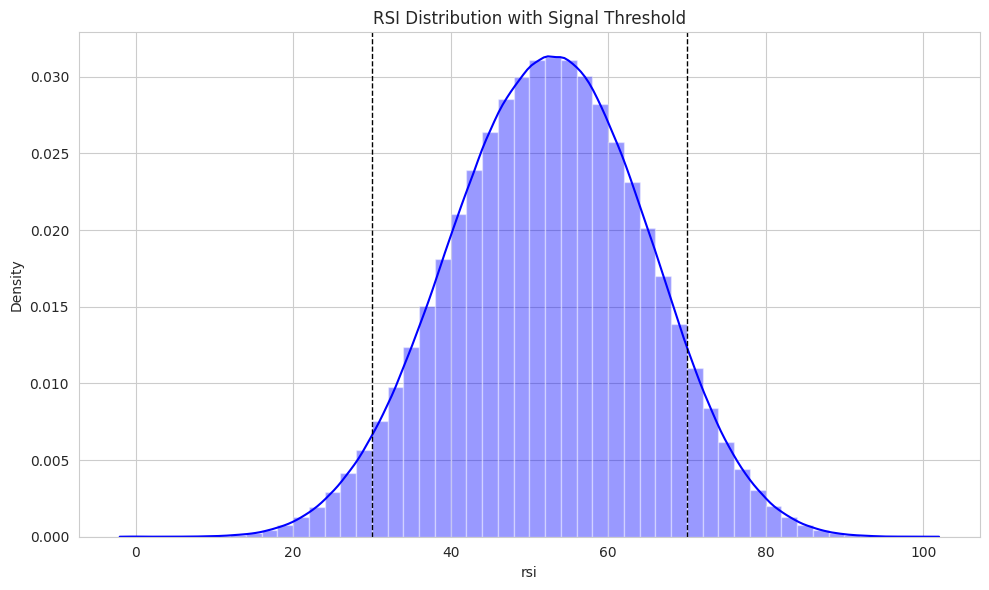

In [ ]:
# Define a function to compute RSI
def compute_rsi(group, window=14):
    return RSI(group, timeperiod=window)

# Calculate RSI for each ticker and assign it back to the original DataFrame
prices['rsi'] = prices.groupby('ticker')['close'].transform(compute_rsi)

# Plot the distribution of RSI values
plt.figure(figsize=(10, 6))
ax = sns.distplot(prices.rsi.dropna(), bins=50, color='blue')

# Add vertical lines for RSI signal thresholds
ax.axvline(30, ls='--', lw=1, c='k')
ax.axvline(70, ls='--', lw=1, c='k')

# Set the title of the plot
ax.set_title('RSI Distribution with Signal Threshold')

# Adjust layout for better fit
plt.tight_layout()

# Show the plot
plt.show()


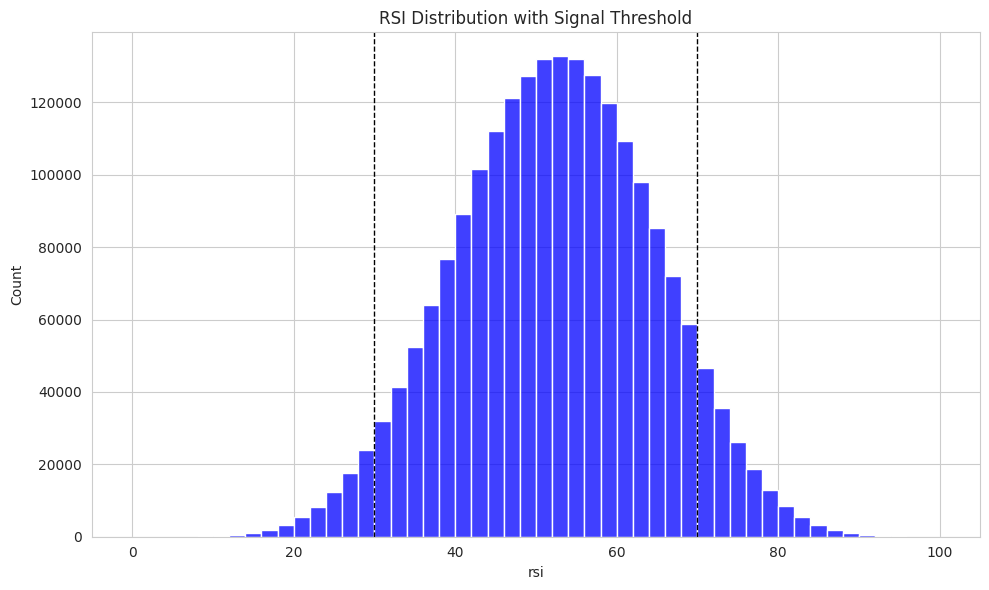

In [ ]:
# Plot the distribution of RSI values
plt.figure(figsize=(10, 6))
ax = sns.histplot(prices.rsi.dropna(), kde=False, bins=50, color='blue')

# Add vertical lines for RSI signal thresholds
ax.axvline(30, ls='--', lw=1, c='k')
ax.axvline(70, ls='--', lw=1, c='k')

# Set the title of the plot
ax.set_title('RSI Distribution with Signal Threshold')

# Adjust layout for better fit
plt.tight_layout()

# Show the plot
plt.show()


## Compute Bollinger Bands

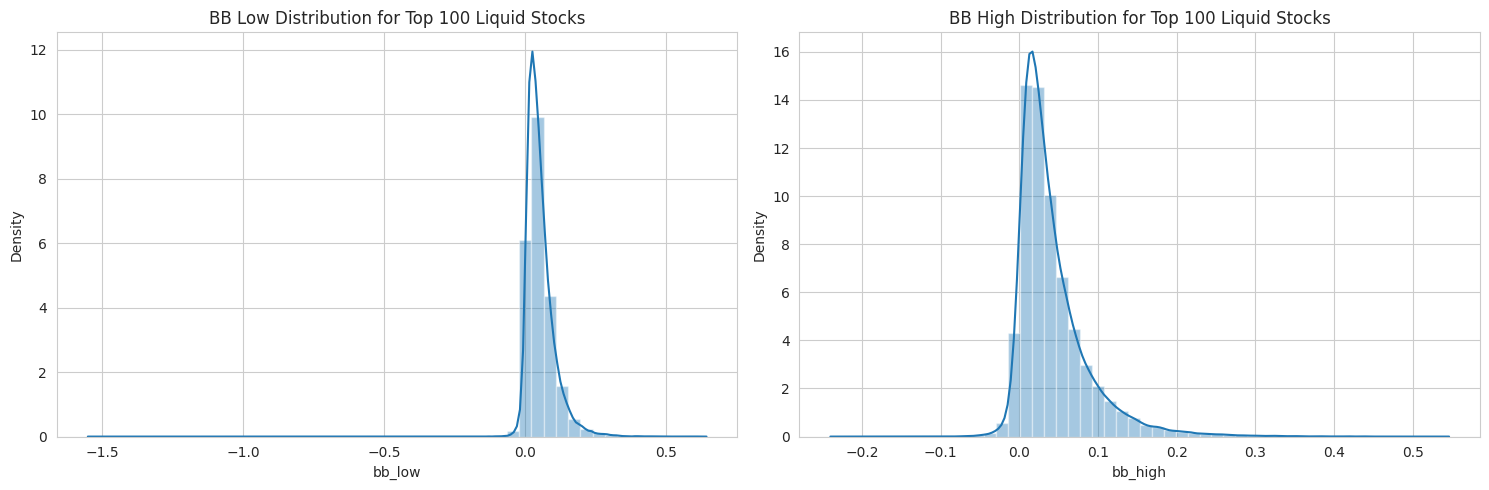

In [ ]:
# Define a function to compute Bollinger Bands
def compute_bb(group):
    high, mid, low = BBANDS(group['close'], timeperiod=20)
    group['bb_high'] = high
    group['bb_low'] = low
    return group

# Calculate Bollinger Bands for each ticker
prices = prices.groupby('ticker').apply(compute_bb)

# Calculate normalized Bollinger Bands features
prices['bb_high'] = prices.bb_high.sub(prices.close).div(prices.bb_high).apply(np.log1p)
prices['bb_low'] = prices.close.sub(prices.bb_low).div(prices.close).apply(np.log1p)

# Plot the distributions of bb_low and bb_high for the most liquid stocks
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))

# Plot distribution for bb_low
sns.distplot(prices.loc[prices.dollar_vol_rank < 100, 'bb_low'].dropna(), ax=axes[0])
axes[0].set_title('BB Low Distribution for Top 100 Liquid Stocks')

# Plot distribution for bb_high
sns.distplot(prices.loc[prices.dollar_vol_rank < 100, 'bb_high'].dropna(), ax=axes[1])
axes[1].set_title('BB High Distribution for Top 100 Liquid Stocks')

# Adjust layout for better fit
plt.tight_layout()

# Show the plots
plt.show()



## Compute Average True Range

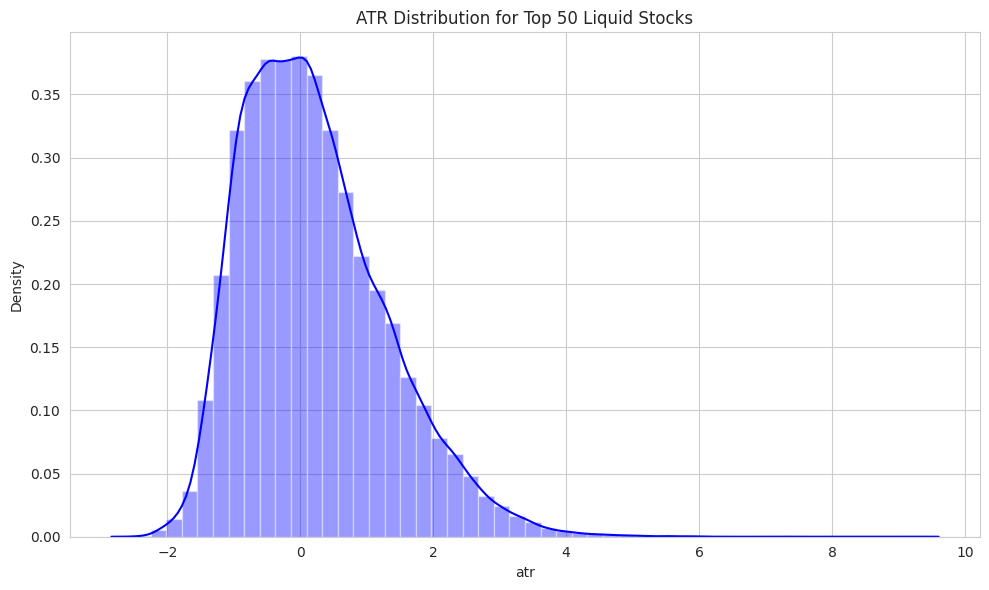

In [ ]:
# Define a function to compute and normalize ATR
def compute_atr(stock_data):
    df = ATR(stock_data.high, stock_data.low, stock_data.close, timeperiod=14)
    return df.sub(df.mean()).div(df.std())

# Calculate and normalize ATR for each ticker
prices['atr'] = prices.groupby('ticker', group_keys=False).apply(compute_atr)

# Plot the distribution of ATR for the most liquid stocks
plt.figure(figsize=(10, 6))
sns.distplot(prices[prices.dollar_vol_rank < 50].atr.dropna(), bins=50, color='blue')
plt.title('ATR Distribution for Top 50 Liquid Stocks')
plt.tight_layout()
plt.show()


## Compute Moving Average Convergence/Divergence

In [ ]:
# Define a function to compute and normalize MACD
def compute_macd(close):
    macd = MACD(close)[0]
    return (macd - np.mean(macd)) / np.std(macd)

# Calculate and normalize MACD for each ticker
prices['macd'] = (prices
                  .groupby('ticker', group_keys=False)
                  .close
                  .apply(compute_macd))

# Describe the MACD distribution with specific percentiles
macd_description = prices.macd.describe(percentiles=[.001, .01, .02, .03, .04, .05, .95, .96, .97, .98, .99, .999])
formatted_description = macd_description.apply(lambda x: f'{x:,.1f}')

formatted_description


,macd
count,"2,088,195.0"
mean,0.0
std,1.0
min,-10.5
0.1%,-4.0
1%,-2.6
2%,-2.2
3%,-2.0
4%,-1.8
5%,-1.6


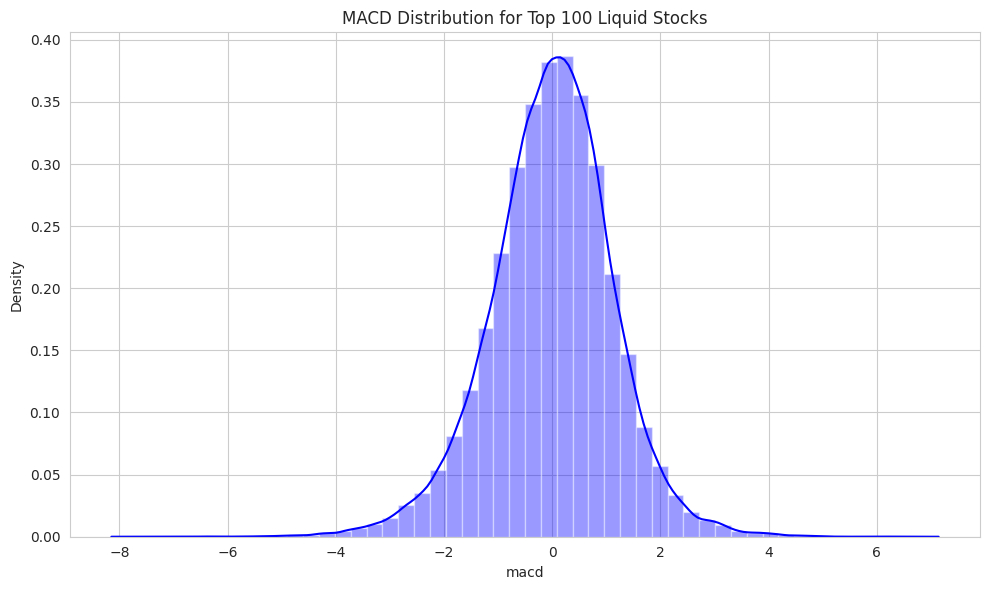

In [ ]:
# Plot the distribution of MACD for the most liquid stocks
plt.figure(figsize=(10, 6))
sns.distplot(prices[prices.dollar_vol_rank < 100].macd.dropna(), bins=50, color='blue')
plt.title('MACD Distribution for Top 100 Liquid Stocks')
plt.tight_layout()
plt.show()


## Compute Lagged Returns

In [ ]:
# Check the MultiIndex levels
print(prices.index.names)

# Remove the extra ticker level if present
if prices.index.names == ['ticker', 'ticker', 'date']:
    prices = prices.reset_index(level=0, drop=True)

# Verify the corrected MultiIndex levels
print(prices.index.names)


['ticker', 'ticker', 'date']
['ticker', 'date']


In [ ]:
# Check the MultiIndex levels
print(prices.index.names)

# Swap the levels if necessary
if prices.index.names == ['ticker', 'date']:
    prices = prices.swaplevel('ticker', 'date')

# Verify the corrected MultiIndex levels
print(prices.index.names)


['ticker', 'date']
['date', 'ticker']


In [ ]:
# Define lags for returns calculation
lags = [1, 5, 10, 21, 42, 63]

# Calculate percentage change in closing prices for each ticker
returns = prices.groupby(level='ticker').close.pct_change()

# Define percentiles to describe returns distribution
percentiles = [0.0001, 0.001, 0.01]
percentiles += [1 - p for p in percentiles]

# Describe the returns distribution using specific percentiles and format the output
returns_description = returns.describe(percentiles=percentiles).iloc[2:].to_frame('percentiles')
returns_description.style.format(lambda x: f'{x:,.2%}')


,percentiles
std,3.12%
min,-87.57%
0.01%,-29.99%
0.1%,-13.45%
1%,-5.97%
50%,0.05%
99%,6.37%
99.9%,15.53%
99.99%,33.85%
max,"2,588.17%"


## Winsorize Outliers and Calculate Returns



In [ ]:
# Define the quantile for Winsorizing
q = 0.0001

# Winsorize outliers and calculate returns for different lags
for lag in lags:
    prices[f'return_{lag}d'] = (prices
                                .groupby(level='ticker')
                                .close
                                .pct_change(lag)
                                .pipe(lambda x: x.clip(lower=x.quantile(q), upper=x.quantile(1 - q)))
                                .add(1)
                                .pow(1 / lag)
                                .sub(1))


## Shift Lagged Returns



In [ ]:
# Shift lagged returns
for t in [1, 2, 3, 4, 5]:
    for lag in [1, 5, 10, 21]:
        prices[f'return_{lag}d_lag{t}'] = (prices
                                           .groupby(level='ticker')
                                           [f'return_{lag}d']
                                           .shift(t * lag))


## Compute Forward Returns



In [ ]:
# Compute forward returns
for t in [1, 5, 10, 21]:
    prices[f'target_{t}d'] = prices.groupby(level='ticker')[f'return_{t}d'].shift(-t)


## Combine Price and Meta Data



In [ ]:
# Combine price data with sector information from the stocks DataFrame
prices = prices.join(stocks[['sector']])


## Create Time and Sector Dummy Variables




In [ ]:
# Create time dummy variables for year and month
prices['year'] = prices.index.get_level_values('date').year
prices['month'] = prices.index.get_level_values('date').month

# Display information about the prices DataFrame including null counts
prices.info(show_counts=True)


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2145582 entries, (Timestamp('2013-01-02 00:00:00'), 'A') to (Timestamp('2017-12-29 00:00:00'), 'ZUMZ')
Data columns (total 46 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   open             2145582 non-null  float64
 1   close            2145582 non-null  float64
 2   low              2145582 non-null  float64
 3   high             2145582 non-null  float64
 4   volume           2145582 non-null  float64
 5   dollar_vol       2145582 non-null  float64
 6   dollar_vol_1m    2110802 non-null  float64
 7   dollar_vol_rank  2110802 non-null  float64
 8   rsi              2121236 non-null  float64
 9   bb_high          2112541 non-null  float64
 10  bb_low           2112526 non-null  float64
 11  atr              2121236 non-null  float64
 12  macd             2088195 non-null  float64
 13  return_1d        2143843 non-null  float64
 14  return_5d        2136887 non-null  float6

## Assign Sector Codes and Save Data without Dummies



In [ ]:
# Assign numeric codes to the sector variable and save the data without dummy variables
prices_no_dummies = prices.assign(sector=pd.factorize(prices.sector, sort=True)[0])
prices_no_dummies.to_hdf('data.h5', 'model_data/no_dummies')


## Create Dummy Variables for Year, Month, and Sector



In [ ]:
# Create dummy variables for year, month, and sector
prices = pd.get_dummies(prices,
                        columns=['year', 'month', 'sector'],
                        prefix=['year', 'month', ''],
                        prefix_sep=['_', '_', ''],
                        drop_first=True)

# Display information about the prices DataFrame including null counts
prices.info(show_counts=True)


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2145582 entries, (Timestamp('2013-01-02 00:00:00'), 'A') to (Timestamp('2017-12-29 00:00:00'), 'ZUMZ')
Data columns (total 69 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   open                    2145582 non-null  float64
 1   close                   2145582 non-null  float64
 2   low                     2145582 non-null  float64
 3   high                    2145582 non-null  float64
 4   volume                  2145582 non-null  float64
 5   dollar_vol              2145582 non-null  float64
 6   dollar_vol_1m           2110802 non-null  float64
 7   dollar_vol_rank         2110802 non-null  float64
 8   rsi                     2121236 non-null  float64
 9   bb_high                 2112541 non-null  float64
 10  bb_low                  2112526 non-null  float64
 11  atr                     2121236 non-null  float64
 12  macd                    2088195 non-nul

## Store Model Data



In [ ]:
# Store the processed model data in an HDF5 file
prices.to_hdf('data.h5', 'model_data')


## Explore Data



### Plot Factors


In [ ]:
# Define the target variable
target = 'target_5d'

# Filter the top 100 most liquid stocks
top100 = prices[prices.dollar_vol_rank < 100].copy()

# Create RSI signal categories
top100.loc[:, 'rsi_signal'] = pd.cut(top100.rsi, bins=[0, 30, 70, 100])

# Group by RSI signal and describe the target returns
rsi_signal_desc = top100.groupby('rsi_signal')[target].describe()
rsi_signal_desc


,count,mean,std,min,25%,50%,75%,max
rsi_signal,,,,,,,,
"(0, 30]",3993.0,0.001287,0.009963,-0.054536,-0.003342,0.001149,0.006165,0.061068
"(30, 70]",107329.0,0.000470,0.007430,-0.147756,-0.002996,0.000655,0.004215,0.073075
"(70, 100]",10755.0,0.000119,0.006277,-0.087857,-0.002717,0.000207,0.003156,0.058570


### Bollinger Bands



Spearman correlation: -2.43% (p-value: 0.00%)


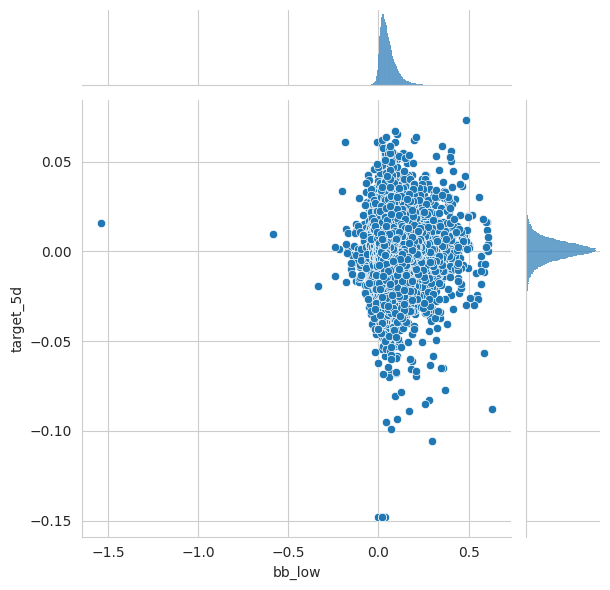

In [ ]:
# Define the metric to analyze
metric = 'bb_low'

# Plot the relationship between the Bollinger Bands metric and the target returns
j = sns.jointplot(x=metric, y=target, data=top100)

# Drop missing values for correlation calculation
df = top100[[metric, target]].dropna()

# Calculate the Spearman correlation between the Bollinger Bands metric and the target returns
r, p = spearmanr(df[metric], df[target])
print(f'Spearman correlation: {r:,.2%} (p-value: {p:.2%})')


Spearman correlation: 4.42% (p-value: 0.00%)


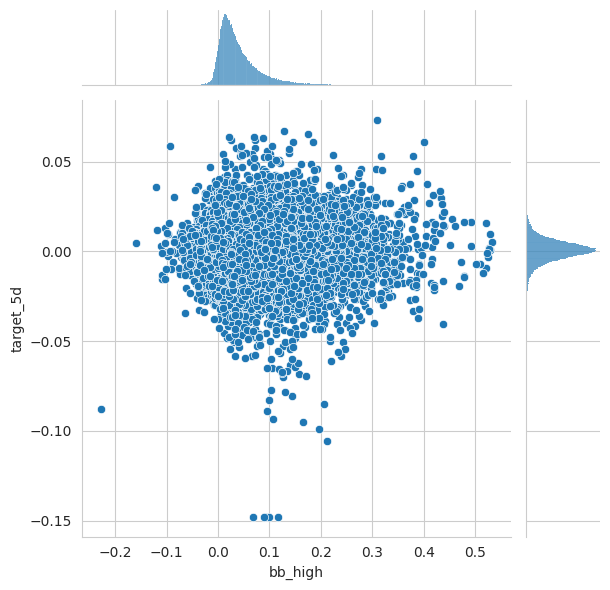

In [ ]:
# Define the metric to analyze
metric = 'bb_high'

# Plot the relationship between the Bollinger Bands high metric and the target returns
j = sns.jointplot(x=metric, y=target, data=top100)

# Drop missing values for correlation calculation
df = top100[[metric, target]].dropna()

# Calculate the Spearman correlation between the Bollinger Bands high metric and the target returns
r, p = spearmanr(df[metric], df[target])
print(f'Spearman correlation: {r:,.2%} (p-value: {p:.2%})')


### Average True Range (ATR)

We will analyze the relationship between the Average True Range (`atr`) and the target returns.


Spearman correlation: -0.15% (p-value: 61.17%)


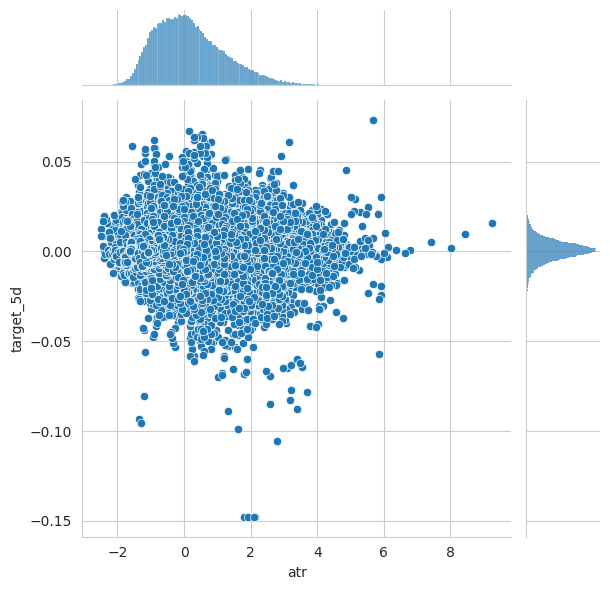

In [ ]:
# Define the metric to analyze
metric = 'atr'

# Plot the relationship between the ATR metric and the target returns
j = sns.jointplot(x=metric, y=target, data=top100)

# Drop missing values for correlation calculation
df = top100[[metric, target]].dropna()

# Calculate the Spearman correlation between the ATR metric and the target returns
r, p = spearmanr(df[metric], df[target])
print(f'Spearman correlation: {r:,.2%} (p-value: {p:.2%})')


### Moving Average Convergence Divergence (MACD)

We will analyze the relationship between the Moving Average Convergence Divergence (`macd`) and the target returns.


Spearman correlation: -4.88% (p-value: 0.00%)


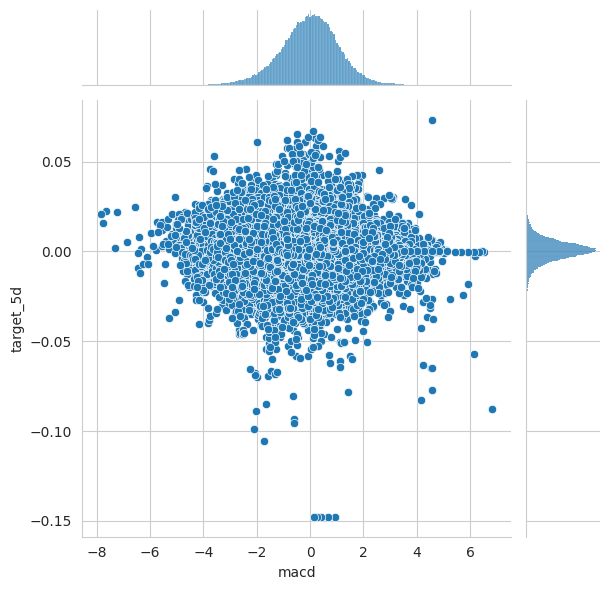

In [ ]:
# Define the metric to analyze
metric = 'macd'

# Plot the relationship between the MACD metric and the target returns
j = sns.jointplot(x=metric, y=target, data=top100)

# Drop missing values for correlation calculation
df = top100[[metric, target]].dropna()

# Calculate the Spearman correlation between the MACD metric and the target returns
r, p = spearmanr(df[metric], df[target])
print(f'Spearman correlation: {r:,.2%} (p-value: {p:.2%})')


In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define the path to save the file in Google Drive
file_path = '/content/drive/MyDrive/ML4T/data.h5'

# Save the file to Google Drive
prices.to_hdf(file_path, 'model_data')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
